# Proof of concept notebook for the Frame Booster project
- Author: Kamil Barszczak
- Contact: kamilbarszczak62@gmail.com
- Project: https://github.com/kbarszczak/Frame_booster

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import tqdm
import time
import cv2
import os

import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchsummary
import torchvision
import torch

#### Notebook parameters

In [2]:
base_path = 'E:/Data/Video_Frame_Interpolation/processed/vimeo90k_pytorch'
data_subdir = 'data'
vis_subdir = 'vis'
train_ids = 'train.txt'
test_ids = 'test.txt'
valid_ids = 'valid.txt'
vis_ids = 'vis.txt'

width, height = 256, 144
epochs = 4
batch = 2

#### Setup device

In [3]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


#### Load datasets

In [4]:
class ByteImageDataset(data.Dataset):
    def __init__(self, path, subdir, split_filename, shape):
        self.path = path
        self.subdir = subdir
        self.shape = shape
        self.ids = pd.read_csv(os.path.join(path, split_filename), names=["ids"])
        
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_path = os.path.join(self.path, self.subdir, str(self.ids.iloc[idx, 0]))
        imgs = [
            self._read_bytes_to_tensor(os.path.join(img_path, 'im1')),
            self._read_bytes_to_tensor(os.path.join(img_path, 'im3'))
        ]
        true = self._read_bytes_to_tensor(os.path.join(img_path, 'im2'))
        return imgs, true
    
    def _read_bytes_to_tensor(self, path):
        with open(path, 'rb') as bf:
            return torch.from_numpy(np.transpose(np.reshape(np.frombuffer(bf.read(), dtype='float32'), self.shape), (2, 0, 1)).copy())

In [5]:
train_dataloader = data.DataLoader(
    dataset = ByteImageDataset(
        path = base_path,
        subdir = data_subdir,
        split_filename = train_ids,
        shape = (height, width, 3)
    ),
    shuffle = True,
    batch_size = batch,
    drop_last = True
)

test_dataloader = data.DataLoader(
    dataset = ByteImageDataset(
        path = base_path,
        subdir = data_subdir,
        split_filename = test_ids,
        shape = (height, width, 3)
    ),
    batch_size = batch,
    drop_last = True
)

valid_dataloader = data.DataLoader(
    dataset = ByteImageDataset(
        path = base_path,
        subdir = data_subdir,
        split_filename = valid_ids,
        shape = (height, width, 3)
    ),
    batch_size = batch,
    drop_last = True
)

vis_dataloader = data.DataLoader(
    dataset = ByteImageDataset(
        path = base_path,
        subdir = vis_subdir,
        split_filename = vis_ids,
        shape = (height, width, 3)
    ),
    batch_size = batch,
    drop_last = True,
    shuffle = False
)

In [6]:
print(f'Training batches: {len(train_dataloader)}')
print(f'Testing batches: {len(test_dataloader)}')
print(f'Validating batches: {len(valid_dataloader)}')
print(f'Visualizing batches: {len(vis_dataloader)}')

Training batches: 25000
Testing batches: 1500
Validating batches: 500
Visualizing batches: 510


#### Create the model

In [7]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        self.__name__ = "perceptual"
        blocks = []
        blocks.append(torchvision.models.vgg16(weights='DEFAULT').features[:4].eval().to(device))
        blocks.append(torchvision.models.vgg16(weights='DEFAULT').features[4:9].eval().to(device))
        blocks.append(torchvision.models.vgg16(weights='DEFAULT').features[9:16].eval().to(device))
        blocks.append(torchvision.models.vgg16(weights='DEFAULT').features[16:23].eval().to(device))
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = nn.ModuleList(blocks).to(device)
        self.transform = F.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += F.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss

    
def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))


def mse(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)


def psnr(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2)
    psnr = 20 * torch.log10(1 / torch.sqrt(mse))
    return 1 - psnr / 40.0


perceptual_loss = VGGPerceptualLoss()
    
    
def loss(y_true, y_pred):
    perceptual_loss_ = perceptual_loss(y_true, y_pred)
    psnr_ = psnr(y_true, y_pred)
    mse_ = mse(y_true, y_pred)
    mae_ = mae(y_true, y_pred)
    
    return 0.5*perceptual_loss_ + psnr_ + 5.0*mae_ + 10.0*mse_

In [8]:
class TReLU(nn.Module):
    def __init__(self, lower=0.0, upper=1.0, **kwargs):
        super(TReLU, self).__init__(**kwargs)
        self.lower = lower
        self.upper = upper

    def forward(self, x):
        return torch.clip(x, min=self.lower, max=self.upper)

In [9]:
class FlowFeatureWarp(nn.Module):
    def __init__(self, input_channels, level,
                 flow_info = {
                    "filter_counts": [96, 96, 64, 48, 32],
                    "filter_sizes": [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
                    "filter_paddings": [1, 1, 1, 1, 1]
                 }, **kwargs):
        super(FlowFeatureWarp, self).__init__(**kwargs)
        
        fcounts = flow_info['filter_counts']
        fsizes = flow_info['filter_sizes']
        fpads = flow_info['filter_paddings']
        
        assert len(fcounts) == len(fsizes) == len(fpads) == 5, "Filter options should have the same size of 5 elements"
        
        # flow estimation layers
        input_channels = 2*input_channels + (2 if level != 4 else 0)
        self.cnn_1 = nn.Conv2d(input_channels, fcounts[0], fsizes[0], padding=fpads[0])
        self.cnn_2 = nn.Conv2d(input_channels + fcounts[0], fcounts[1], fsizes[1], padding=fpads[1])
        self.cnn_3 = nn.Conv2d(input_channels + fcounts[0] + fcounts[1], fcounts[2], fsizes[2], padding=fpads[2])
        self.cnn_4 = nn.Conv2d(input_channels + fcounts[0] + fcounts[1] + fcounts[2], fcounts[3], fsizes[3], padding=fpads[3])
        self.cnn_5 = nn.Conv2d(input_channels + fcounts[0] + fcounts[1] + fcounts[2] + fcounts[3], fcounts[4], fsizes[4], padding=fpads[4])
        
        self.cnn_out = nn.Conv2d(input_channels + fcounts[0] + fcounts[1] + fcounts[2] + fcounts[3] + fcounts[4], 2, 3, 1, 1)
        self.upsample = nn.Upsample(scale_factor=(2, 2), mode='bilinear', align_corners=True)
        
        self.level = level

    def forward(self, input_1, input_2, upsampled_flow_1_2, upsampled_flow_2_1):
        if self.level != 4:
            # flow from input 1 to input 2
            x_1_2 = FlowFeatureWarp.warp(input_1, upsampled_flow_1_2)
            x_1_2 = torch.cat([x_1_2, input_2, upsampled_flow_1_2], dim=1)
            # flow from input 2 to input 1
            x_2_1 = FlowFeatureWarp.warp(input_2, upsampled_flow_2_1)
            x_2_1 = torch.cat([input_1, x_2_1, upsampled_flow_2_1], dim=1)
        else:
            x_1_2 = torch.cat([input_1, input_2], dim=1)
            x_2_1 = torch.cat([input_1, input_2], dim=1)
        
        # flow from input 1 to input 2
        x_1_2 = torch.cat([self.cnn_1(x_1_2), x_1_2], dim=1)
        x_1_2 = torch.cat([self.cnn_2(x_1_2), x_1_2], dim=1)
        x_1_2 = torch.cat([self.cnn_3(x_1_2), x_1_2], dim=1)
        x_1_2 = torch.cat([self.cnn_4(x_1_2), x_1_2], dim=1)
        x_1_2 = torch.cat([self.cnn_5(x_1_2), x_1_2], dim=1)
        flow_1_2 = self.cnn_out(x_1_2)
        
        # flow from input 2 to input 1
        x_2_1 = torch.cat([self.cnn_1(x_2_1), x_2_1], dim=1)
        x_2_1 = torch.cat([self.cnn_2(x_2_1), x_2_1], dim=1)
        x_2_1 = torch.cat([self.cnn_3(x_2_1), x_2_1], dim=1)
        x_2_1 = torch.cat([self.cnn_4(x_2_1), x_2_1], dim=1)
        x_2_1 = torch.cat([self.cnn_5(x_2_1), x_2_1], dim=1)
        flow_2_1 = self.cnn_out(x_2_1)
        
        # warp features
        input_1_warped = FlowFeatureWarp.warp(input_1, flow_1_2 * 0.5)
        input_2_warped = FlowFeatureWarp.warp(input_2, flow_2_1 * 0.5)
        
        # upsample flow
        flow_1_2_upsampled = self.upsample(flow_1_2) * 2
        flow_2_1_upsampled = self.upsample(flow_2_1) * 2
        
        return input_1_warped, input_2_warped, flow_1_2_upsampled, flow_2_1_upsampled
    
    @staticmethod
    def warp(image: torch.Tensor, flow: torch.Tensor) -> torch.Tensor:
        B, C, H, W = image.size()

        xx = torch.arange(0, W).view(1 ,-1).repeat(H, 1)
        yy = torch.arange(0, H).view(-1 ,1).repeat(1, W)
        xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
        yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)

        grid = torch.cat((xx, yy), 1).float()
        if image.is_cuda:
            grid = grid.cuda()

        vgrid = grid + flow
        vgrid[:, 0, :, :] = 2.0 * vgrid[: ,0 ,: ,:].clone() / max(W - 1, 1) - 1.0
        vgrid[:, 1, :, :] = 2.0 * vgrid[: ,1 ,: ,:].clone() / max(H - 1, 1) - 1.0

        vgrid = vgrid.permute(0, 2, 3, 1)
        flow = flow.permute(0, 2, 3, 1)
        output = F.grid_sample(image, vgrid, align_corners=False)

        return output

In [10]:
class AttentionGate(nn.Module):
    def __init__(self, g_filters, x_filters, filters, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        
        self.gcnn = nn.Conv2d(g_filters, filters, 3, 1, 1)
        self.xcnn = nn.Conv2d(x_filters, filters, 3, 2, 1)
        self.ocnn = nn.Conv2d(filters, 1, 1)
        self.upsample = nn.Upsample(scale_factor=(2, 2), mode='bilinear')
        self.act = nn.PReLU()
        self.out_act = nn.Sigmoid()

    def forward(self, g, x):
        xcnn = self.xcnn(x)
        gcnn = self.gcnn(g)
        
        xg = xcnn + gcnn
        
        xg = self.act(xg)
        xg = self.ocnn(xg)
        xg = self.out_act(xg)
        xg = self.upsample(xg)
        
        return x * xg

In [11]:
class Conv2dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, **kwargs):
        super(Conv2dBlock, self).__init__(**kwargs)
        
        self.cnn_1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.act_1 = nn.PReLU()
        self.cnn_2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.act_2 = nn.PReLU()

    def forward(self, x):
        x = self.act_1(self.cnn_1(x))
        x = self.act_2(self.cnn_2(x))
        return x

In [12]:
class FBNet(nn.Module):
    def __init__(self, input_shape, device, filters=[32, 32, 32, 32], **kwargs):
        super(FBNet, self).__init__(**kwargs)
        
        self.b = input_shape[0]
        self.c = input_shape[1]
        self.h = input_shape[2]
        self.w = input_shape[3]
        
        # ------------- Feature encoding layers
        self.cnn_block_r1 = Conv2dBlock(self.c, filters[0], 3, 1, 1)
        self.cnn_block_r2 = Conv2dBlock(self.c + filters[0], filters[1], 3, 1, 1)
        self.cnn_block_r3 = Conv2dBlock(self.c + filters[0] + filters[1], filters[2], 3, 1, 1)
        self.cnn_block_r4 = Conv2dBlock(self.c + filters[0] + filters[1] + filters[2], filters[3], 3, 1, 1)
        
        self.avg_r1 = nn.AvgPool2d((2, 2))
        self.avg_r2 = nn.AvgPool2d((2, 2))
        self.avg_r3 = nn.AvgPool2d((2, 2))
        
        # ------------- Feature warping layers 
        self.flow_warp_r1 = FlowFeatureWarp(
            input_channels=self.c + filters[0],
            level = 1
        )
        self.flow_warp_r2 = FlowFeatureWarp(
            input_channels=self.c + filters[0] + filters[1],
            level = 2 
        )
        self.flow_warp_r3 = FlowFeatureWarp(
            input_channels=self.c + filters[0] + filters[1] + filters[2],
            level = 3 
        )
        self.flow_warp_r4 = FlowFeatureWarp(
            input_channels=self.c + filters[0] + filters[1] + filters[2] + filters[3],
            level = 4 
        )
        
        # ------------- Attention layers
        self.attention_r1 = AttentionGate(
            g_filters=self.c + filters[0], 
            x_filters=self.c + filters[0], 
            filters=self.c + filters[0]
        )
        self.attention_r2 = AttentionGate(
            g_filters=self.c + filters[0] + filters[1], 
            x_filters=self.c + filters[0] + filters[1], 
            filters=self.c + filters[0] + filters[1]
        )
        self.attention_r3 = AttentionGate(
            g_filters=self.c + filters[0] + filters[1] + filters[2], 
            x_filters=self.c + filters[0] + filters[1] + filters[2], 
            filters=self.c + filters[0] + filters[1] + filters[2]
        )
        
        # ------------- Feature decoding layers
        self.conv_dec_block_r4 = Conv2dBlock(self.c + filters[0] + filters[1] + filters[2] + filters[3], self.c + filters[0] + filters[1] + filters[2], 3, 1, 1)
        self.up_r4 = nn.Upsample(scale_factor=(2, 2), mode='bilinear', align_corners=True)
        
        self.conv_dec_block_r3 = Conv2dBlock(self.c + filters[0] + filters[1] + filters[2], self.c + filters[0] + filters[1], 3, 1, 1)
        self.up_r3 = nn.Upsample(scale_factor=(2, 2), mode='bilinear', align_corners=True)
        
        self.conv_dec_block_r2 = Conv2dBlock(self.c + filters[0] + filters[1], self.c + filters[0], 3, 1, 1)
        self.up_r2 = nn.Upsample(scale_factor=(2, 2), mode='bilinear', align_corners=True)
        
        self.conv_dec_block_r1 = Conv2dBlock(self.c + filters[0], self.c, 3, 1, 1)
        self.act_out = TReLU()
        
    def forward(self, left, right):
        # ------------- Process left input
        # first conv block
        input_left_cnn_r1 = torch.cat([self.cnn_block_r1(left), left], dim=1)
        input_left_avg_r1 = self.avg_r1(input_left_cnn_r1)
        
        # second conv block
        input_left_cnn_r2 = torch.cat([self.cnn_block_r2(input_left_avg_r1), input_left_avg_r1], dim=1)
        input_left_avg_r2 = self.avg_r2(input_left_cnn_r2)
        
        # third conv block
        input_left_cnn_r3 = torch.cat([self.cnn_block_r3(input_left_avg_r2), input_left_avg_r2], dim=1)
        input_left_avg_r3 = self.avg_r3(input_left_cnn_r3)
        
        # fourth conv block
        input_left_cnn_r4 = torch.cat([self.cnn_block_r4(input_left_avg_r3), input_left_avg_r3], dim=1)
        
        # output:
        # * input_left_cnn_r1
        # * input_left_cnn_r2
        # * input_left_cnn_r3
        # * input_left_cnn_r4

        # ------------- Process right input
        # first conv block
        input_right_cnn_r1 = torch.cat([self.cnn_block_r1(right), right], dim=1)
        input_right_avg_r1 = self.avg_r1(input_right_cnn_r1)
        
        # second conv block
        input_right_cnn_r2 = torch.cat([self.cnn_block_r2(input_right_avg_r1), input_right_avg_r1], dim=1)
        input_right_avg_r2 = self.avg_r2(input_right_cnn_r2)
        
        # third conv block
        input_right_cnn_r3 = torch.cat([self.cnn_block_r3(input_right_avg_r2), input_right_avg_r2], dim=1)
        input_right_avg_r3 = self.avg_r3(input_right_cnn_r3)
        
        # fourth conv block
        input_right_cnn_r4 = torch.cat([self.cnn_block_r4(input_right_avg_r3), input_right_avg_r3], dim=1)
        
        # output:
        # * input_right_cnn_r1
        # * input_right_cnn_r2
        # * input_right_cnn_r3
        # * input_right_cnn_r4
        # ------------- Warp features
        warp_left_r4, warp_right_r4, flow_1_2_r4, flow_2_1_r4 = self.flow_warp_r4(input_left_cnn_r4, input_right_cnn_r4, None, None)
        warp_left_r3, warp_right_r3, flow_1_2_r3, flow_2_1_r3= self.flow_warp_r3(input_left_cnn_r3, input_right_cnn_r3, flow_1_2_r4, flow_2_1_r4)
        warp_left_r2, warp_right_r2, flow_1_2_r2, flow_2_1_r2 = self.flow_warp_r2(input_left_cnn_r2, input_right_cnn_r2, flow_1_2_r3, flow_2_1_r3)
        warp_left_r1, warp_right_r1, _, _ = self.flow_warp_r1(input_left_cnn_r1, input_right_cnn_r1, flow_1_2_r2, flow_2_1_r2)
        
        # output:
        # * warp_left_r4, warp_right_r4, 
        # * warp_left_r3, warp_right_r3, 
        # * warp_left_r2, warp_right_r2, 
        # * warp_left_r1, warp_right_r1, 
        
        # ------------- Decode features with attention 
        # row 4
        warp_r4 = self.conv_dec_block_r4(warp_left_r4 + warp_right_r4)
        warp_r4_up = self.up_r4(warp_r4)
        
        # row 3
        warp_r3 = self.attention_r3(warp_r4, warp_left_r3 + warp_right_r3 + warp_r4_up)
        warp_r3 = self.conv_dec_block_r3(warp_r3)
        warp_r3_up = self.up_r3(warp_r3)
        
        # row 2
        warp_r2 = self.attention_r2(warp_r3, warp_left_r2 + warp_right_r2 + warp_r3_up)
        warp_r2 = self.conv_dec_block_r2(warp_r2)
        warp_r2_up = self.up_r2(warp_r2)
        
        # row 1
        warp_r1 = self.attention_r1(warp_r2, warp_left_r1 + warp_right_r1 + warp_r2_up)
        warp_r1 = self.conv_dec_block_r1(warp_r1)
        result = self.act_out(warp_r1)
        
        # output:
        # * result
        
        return result

In [13]:
fbnet = FBNet(input_shape=(batch, 3, height, width), device=device).to(device)
torchsummary.summary(fbnet, [(3, height, width), (3, height, width)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 144, 256]             896
             PReLU-2         [-1, 32, 144, 256]               1
            Conv2d-3         [-1, 32, 144, 256]           9,248
             PReLU-4         [-1, 32, 144, 256]               1
       Conv2dBlock-5         [-1, 32, 144, 256]               0
         AvgPool2d-6          [-1, 35, 72, 128]               0
            Conv2d-7          [-1, 32, 72, 128]          10,112
             PReLU-8          [-1, 32, 72, 128]               1
            Conv2d-9          [-1, 32, 72, 128]           9,248
            PReLU-10          [-1, 32, 72, 128]               1
      Conv2dBlock-11          [-1, 32, 72, 128]               0
        AvgPool2d-12           [-1, 67, 36, 64]               0
           Conv2d-13           [-1, 32, 36, 64]          19,328
            PReLU-14           [-1, 32,

#### Train the model

In [15]:
def plot_triplet(left, right, y, y_pred, figsize=(20, 4)):
    plt.figure(figsize=figsize)
    data = torch.cat([
        torchvision.transforms.functional.rotate(right, 90, expand=True),
        torchvision.transforms.functional.rotate(y_pred, 90, expand=True), 
        torchvision.transforms.functional.rotate(y, 90, expand=True), 
        torchvision.transforms.functional.rotate(left, 90, expand=True)
    ], dim=0)
    grid = torchvision.utils.make_grid(data, nrow=left.shape[0])
    grid = torchvision.transforms.functional.rotate(grid, 270, expand=True)
    plt.imshow(torch.permute(grid, (1, 2, 0)).cpu())
    plt.axis('off')
    plt.show()

In [16]:
def fit(model, train, valid, optimizer, loss, metrics, epochs, batch, save_freq=500, log_freq=1, log_perf_freq=2500, mode="best"):  
    # create dict for a history
    history = {loss.__name__: []} | {metric.__name__: [] for metric in metrics} | {'val_' + loss.__name__: []} | {"val_" + metric.__name__: [] for metric in metrics}
    best_loss = None
    
    # loop over epochs
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")
        
        # create empty dict for loss and metrics
        loss_metrics = {loss.__name__: []} | {metric.__name__: [] for metric in metrics}

        # loop over training batches
        model.train(True)
        for step, record in enumerate(train):
            start = time.time()
            
            # extract the data
            left, right, y = record[0][0].to(device), record[0][1].to(device), record[1].to(device)

            # clear gradient
            model.zero_grad()
            
            # forward pass
            y_pred = model(left, right) 
            
            # calculate loss and apply the gradient
            loss_value = loss(y, y_pred)
            loss_value.backward()
            optimizer.step()
            
            # calculate metrics
            y_pred_detached = y_pred.detach()
            metrics_values = [metric(y, y_pred_detached) for metric in metrics]
            
            # save the loss and metrics
            loss_metrics[loss.__name__].append(loss_value.item())
            for metric, value in zip(metrics, metrics_values):
                loss_metrics[metric.__name__].append(value.item())
                
            end = time.time()
            
            # save the model
            if save_freq is not None and step % save_freq == 0 and step > 0:
                loss_avg = np.mean(loss_metrics[loss.__name__])
                if mode == "all" or (mode == "best" and (best_loss is None or best_loss > loss_avg)):
                    filename = f'../models/model_v6_1/fbnet_l={loss_avg}_e={epoch+1}_t={int(time.time())}.pth'
                    torch.save(model.state_dict(), filename)
                    
            # log the model performance
            if log_perf_freq is not None and step % log_perf_freq == 0 and step > 0:
                plot_triplet(left, right, y, y_pred.detach())
                
            # log the state
            if step % log_freq == 0:
                time_left = (end-start) * (len(train) - (step+1))
                print('\r[%5d/%5d] (eta: %s)' % ((step+1), len(train), time.strftime('%H:%M:%S', time.gmtime(time_left))), end='')
                for metric, values in loss_metrics.items():
                    print(f' {metric}=%.4f' % (np.mean(values)), end='')
            
        # save the training history
        for metric, values in loss_metrics.items():
            history[metric].extend(values)

        # setup dict for validation loss and metrics
        loss_metrics = {loss.__name__: []} | {metric.__name__: [] for metric in metrics}
        
        # process the full validating dataset
        model.train(False)
        for step, record in enumerate(valid):
            left, right, y = record[0][0].to(device), record[0][1].to(device), record[1].to(device)

            # forward pass
            y_pred = model(left, right).detach()
            
            # save the loss and metrics
            loss_metrics[loss.__name__].append(loss(y, y_pred).item())
            for metric, value in zip(metrics, [metric(y, y_pred) for metric in metrics]):
                loss_metrics[metric.__name__].append(value.item())
            
        # log the validation score & save the validation history
        for metric, values in loss_metrics.items():
            print(f' val_{metric}=%.4f' % (np.mean(values)), end='')
            history[f"val_{metric}"].extend(values)
            
        # restart state printer
        print()

    return history

In [17]:
history = fit(
    model = fbnet, 
    train = train_dataloader,
    valid = valid_dataloader,
    optimizer = optim.NAdam(fbnet.parameters(), lr=1e-4), 
    loss = loss, 
    metrics = [psnr],
    epochs = epochs, 
    batch = batch, 
    save_freq = 500,
    log_freq = 1,
    log_perf_freq = 2500,
    mode = "best"
)

Epoch: 1/4
[  174/25000] (eta: 04:25:13) loss=3.9002 psnr=0.6750

KeyboardInterrupt: 

In [ ]:
torch.save(fbnet.state_dict(), f'../models/model_v6_1/fbnet_e={epochs}_t={int(time.time())}.pth')    

#### Evaluate the model

In [ ]:
def norm_0_1(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def compress_loss(loss, steps):
    return [np.average(loss[steps*i:steps*(i+1)]) for i in range(len(loss)//steps)]

def plot_history(history, norm=norm_0_1, figsize=(10,5), steps=None):
    plt.clf()
    plt.figure(figsize=figsize)
    
    metrics = list(history.keys())
    metrics = [metric for metric in metrics if "val" not in metric]
    
    if steps is None:
        data = [(index, history[metric], history['val_'+metric], metric) for index, metric in enumerate(metrics)]
    else:
        tlen = len(history[metrics[0]])
        vlen = len(history['val_'+metrics[0]])
        data = [(index, compress_loss(history[metric], tlen//steps), compress_loss(history['val_'+metric], vlen//steps), metric) for index, metric in enumerate(metrics)]
        
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    epochs = range(1, len(data[0][1]) + 1)
    
    for index, value, val_value, metric in data:
        if norm is not None:
            buffer = norm(value + val_value)
            value = buffer[0:len(epochs)]
            val_value = buffer[len(epochs):]
        
        plt.plot(epochs, value, colors[index], label=f"train {metric}")
        plt.plot(epochs, val_value, colors[index]+'--', label=f"valid {metric}")
        
    plt.title("Comparision of training and validating scores")
    plt.xlabel('Steps')
    plt.ylabel("Values" if norm is None else "Values normalized")
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
def evaluate(model, data, loss, metrics):
    loss_metrics = {loss.__name__: []} | {metric.__name__: [] for metric in metrics}
    model.train(False)
    for step, record in enumerate(data):
        left, right, y = record[0][0].to(device), record[0][1].to(device), record[1].to(device)

        # forward pass
        y_pred = model(left, right).detach()

        # save the loss and metrics
        loss_metrics[loss.__name__].append(loss(y, y_pred).item())
        for metric, value in zip(metrics, [metric(y, y_pred) for metric in metrics]):
            loss_metrics[metric.__name__].append(value.item())
            
        print('\rProgress [%4d/%4d]' % ((step+1), len(data)), end='')
        
    print()
            
    return {k: np.mean(v) for k, v in loss_metrics.items()}

In [ ]:
plot_history(history, norm=None, steps=200)

In [ ]:
plot_history(history, steps=200)

In [ ]:
results = evaluate(fbnet, test_dataloader, loss, [mae, mse, psnr])
for k, v in results.items():
    print('%s: %.6f' % (k, v))

#### Visualize net output

In [18]:
def display_grid(data, nrow, figsize):
    if figsize == 'auto':
        figsize = (20, 5*(data.shape[0]//nrow))
    
    if data is not None:
        plt.figure(figsize=figsize)
        grid = torchvision.utils.make_grid(data, nrow=nrow)
        plt.imshow(torch.permute(grid, (1, 2, 0)).cpu())
        plt.axis('off')
        plt.show()

In [19]:
def visualise_output(model, batches, figsize='auto'):
    data = None
    batch_size = batches[0][1].shape[0]
    model.train(False)
    for batch in batches:
        left, right, y = batch[0][0].to(device), batch[0][1].to(device), batch[1].to(device)
        y_pred = model(left, right).detach()
        for index in range(batch_size):
            cat_list = [
                torch.unsqueeze(left[index, :, :, :], 0),
                torch.unsqueeze(y[index, :, :, :], 0),
                torch.unsqueeze(y_pred[index, :, :, :], 0),
                torch.unsqueeze(right[index, :, :, :], 0)
            ]
            if data is not None:
                cat_list = [data] + cat_list
            data = torch.cat(cat_list, dim=0)
                
    display_grid(data, 4, figsize)

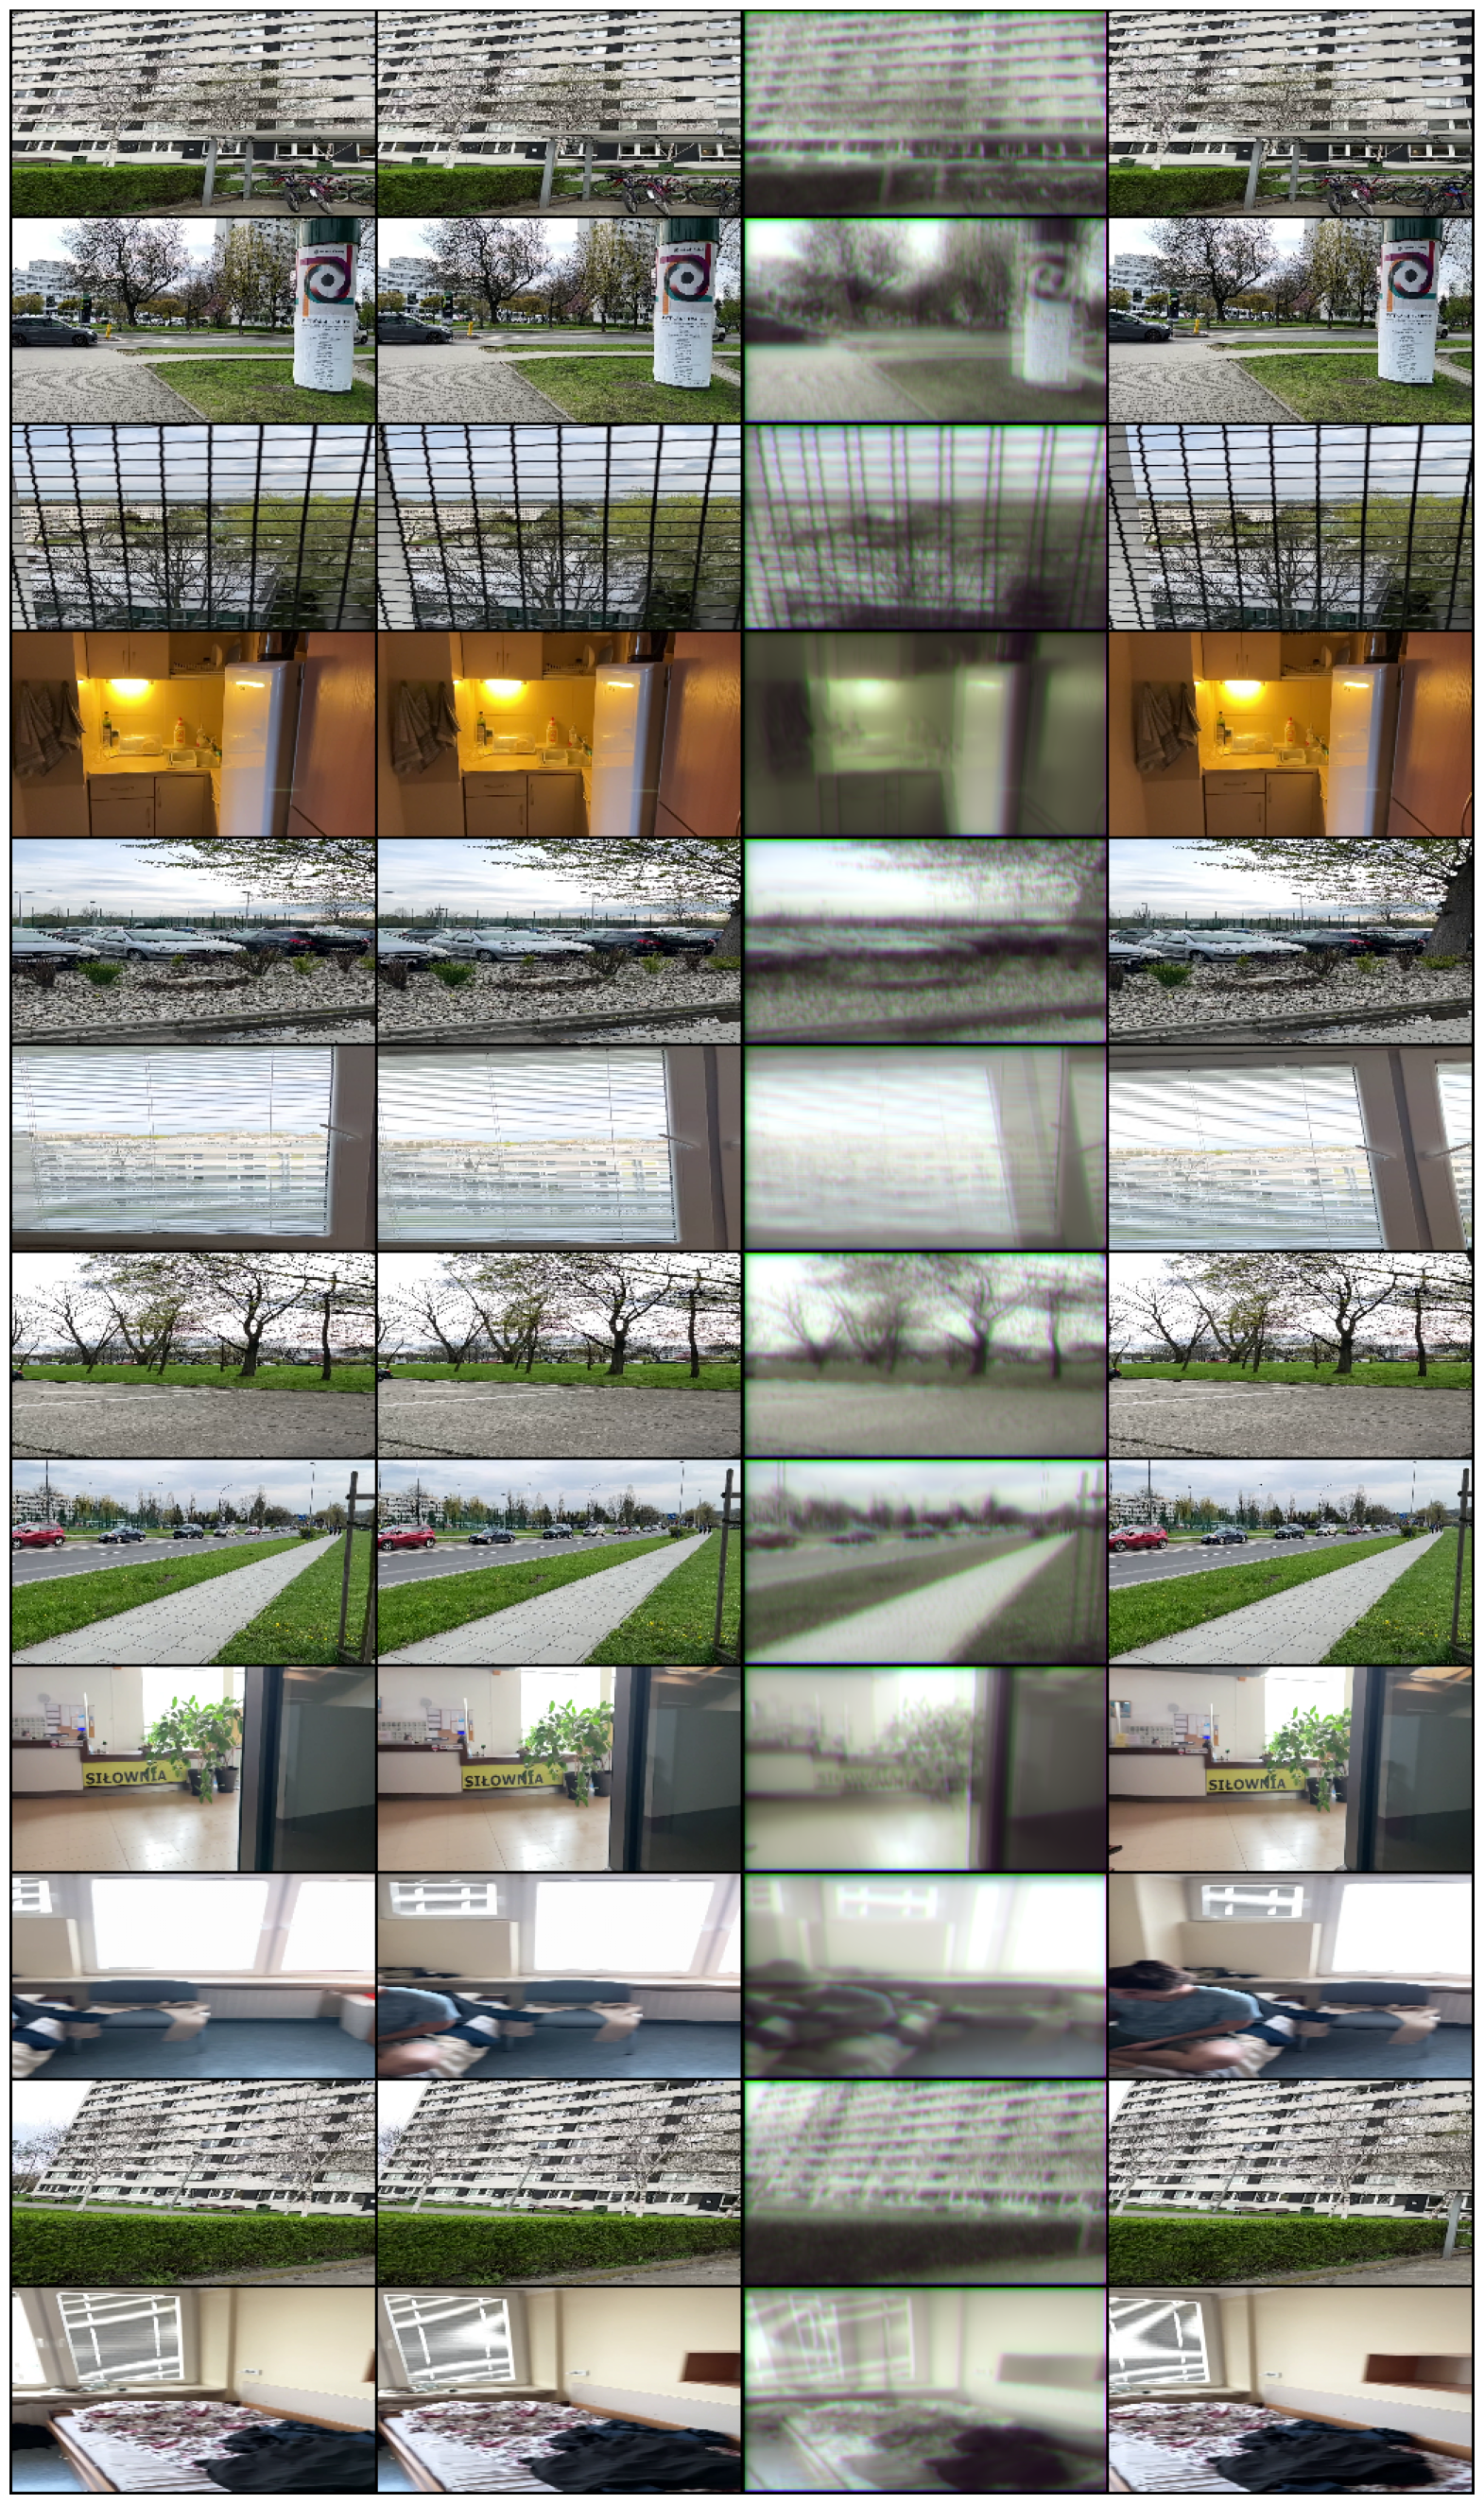

In [20]:
vis_iterator = iter(vis_dataloader)
visualise_output(fbnet, batches=[next(vis_iterator) for bi in range(len(vis_dataloader)) if bi in [0, 1, 2, 3, 4, 5]])

#### Visualize conv2d filters

In [21]:
def vis_conv2d_weight(kernels, all_kernels=True, nrow=32, padding=1, ch=0): 
    b, c, w, h = kernels.shape

    if all_kernels: 
        kernels = kernels.view(b*c, -1, w, h)
    elif c != 3: 
        kernels = kernels[:, ch, :, :].unsqueeze(dim=1)

    rows = np.min((kernels.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(kernels, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow, rows))
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.show()
    
    
def deprocess_image(img):
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    img += 0.5
    img = np.clip(img, 0, 1)

    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    
    return img
    
    
def append_image(image, append_image, row, col, margin):
    horizontal_start = row * height + row * margin
    horizontal_end = horizontal_start + height
    vertical_start = col * width + col * margin
    vertical_end = vertical_start + width
    image[horizontal_start : horizontal_end, vertical_start : vertical_end, : ] = append_image
    return image

    
def rows_cols(value):
    assert value >= 1
    rows, cols = 1, value
    for i in range(2, value//2+1):
        if value % i == 0:
            if np.abs(i - int(value / i)) < np.abs(rows - cols):
                rows = i
                cols = int(value / i)
    return rows, cols
    

def visualize_cnn_layers(model, margin=3, steps=10, lr=0.1, include_nested=True):
    assert margin >= 0, "Margin cannot be negative"
    assert steps > 0, "Steps has to be positive"
    
    activations = {}
    def hook_fun(model, input, output):
        activations['activation'] = output
    
    model.train(False)
    queue = list(model.named_children())
    while queue:
        name, layer = queue.pop(0)
        if include_nested:
            queue.extend([(f'{name}_{n}', l) for n, l in layer.named_children()])
        
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
            print(f"Layer name: {name}")
            
            f_count = layer.out_channels
            rows, cols = rows_cols(f_count)
            result = np.zeros((rows * height + (rows-1) * margin, cols * width + (cols-1) * margin, 3), dtype='uint8')

            for index in tqdm.tqdm(range(rows*cols)):
                i, j = index//cols, index % cols
                filter_index = j + (i * cols)
                
                hook = layer.register_forward_hook(hook_fun)
                noise = (np.random.rand(batch, model.c, model.h, model.w) * 0.2 + 0.4).astype('float32')
                tensor = torch.from_numpy(noise).to(device).requires_grad_(True)
                optimizer = optim.NAdam([tensor], lr=lr)
                
                for step in range(steps):
                    optimizer.zero_grad()
                    _ = model(tensor, tensor)
                    activation = activations['activation'][:, filter_index, :, :].unsqueeze(dim=1)
                    loss = torch.mean(activation)
                    loss.backward()
                    optimizer.step()
                    
                tensor = tensor.detach()[0].permute((1, 2, 0))
                filter_img = deprocess_image(tensor.cpu().numpy())
                result = append_image(result, filter_img, i, j, margin)
                hook.remove()

            plt.figure(figsize=(model.h // 2, model.w // 2))
            plt.imshow(result)
            plt.axis('off')
            plt.show()

In [ ]:
visualize_cnn_layers(fbnet, margin=3, steps=10, lr=0.1, include_nested=True)

In [ ]:
vis_conv2d_weight(fbnet.cnn_r1_1.weight.detach(), nrow=16)

#### Visualize inner optical flows

In [22]:
def visualise_flow(model, batches, figsize='auto'):
    flows, names, hooks = {}, [], []
    
    # hook registration function
    def get_activation(name):
        def hook(model, input, output):
            flows[name] = output[1].detach()
        return hook

    # register hooks
    for child in fbnet.named_children():
        if isinstance(child[1], FlowFeatureWarp):
            hooks.append(child[1].register_forward_hook(get_activation(child[0])))
            names.append(child[0])
            
    # iterate over the given batches
    model.train(False)
    data, batch_size = None, batches[0][1].shape[0]
    resize = torchvision.transforms.Resize((height, width), antialias=True)
    for batch in batches:
        # forward pass (hooks register outputs)
        left, right = batch[0][0].to(device), batch[0][1].to(device)
        _ = model(left, right)
        
        # process each sample in the batch
        for index in range(batch_size):
            cat_list = [torch.unsqueeze(left[index, :, :, :], dim=0)]
            
            for name in names:
                flow = flows[name][index, :, :, :]
                flow = resize(torchvision.utils.flow_to_image(flow)) / 255.0
                cat_list.append(torch.unsqueeze(flow, dim=0))
                
            cat_list.append(torch.unsqueeze(right[index, :, :, :], dim=0))
            
            if data is not None:
                cat_list = [data] + cat_list
                
            data = torch.cat(cat_list, dim=0)

    # display data
    display_grid(data, (2 + len(names)), figsize)
        
    # remove hooks
    for hook in hooks:
        hook.remove()

In [23]:
vis_iterator = iter(vis_dataloader)
visualise_flow(fbnet, batches=[next(vis_iterator) for bi in range(len(vis_dataloader)) if bi in [0, 1, 2, 3, 4, 5]])

ValueError: Input flow should have shape (2, H, W) or (N, 2, H, W), got torch.Size([35, 144, 256]).

#### Visualise attention mask

In [24]:
def visualise_attention(model, batches, figsize='auto'):
    attentions, names, hooks = {}, [], []
    
    # hook registration function
    def get_activation(name, act, upsample):
        def hook(model, input, output):
            attentions[name] = upsample(act(output.detach()))
        return hook

    # register hooks
    for child in model.named_children():
        if isinstance(child[1], AttentionGate):
            hooks.append(child[1].ocnn.register_forward_hook(get_activation(child[0], child[1].out_act, child[1].upsample)))
            names.append(child[0])
            
    # iterate over the given batches
    model.train(False)
    data, batch_size = None, batches[0][1].shape[0]
    resize = torchvision.transforms.Resize((height, width), antialias=True)
    gray2rgb = torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)
    for batch in batches:
        # forward pass (hooks register outputs)
        left, right = batch[0][0].to(device), batch[0][1].to(device)
        _ = model(left, right)
        
        # process each sample in the batch
        for index in range(batch_size):
            cat_list = [torch.unsqueeze(left[index, :, :, :], dim=0)]
            
            for name in names:
                attention = attentions[name][index, :, :, :]
                attention = gray2rgb(resize(attention))
                cat_list.append(torch.unsqueeze(attention, dim=0))
                
            cat_list.append(torch.unsqueeze(right[index, :, :, :], dim=0))
            
            if data is not None:
                cat_list = [data] + cat_list
                
            data = torch.cat(cat_list, dim=0)

    # display data
    display_grid(data, (2 + len(names)), figsize)
        
    # remove hooks
    for hook in hooks:
        hook.remove()

In [25]:
vis_iterator = iter(vis_dataloader)
visualise_attention(fbnet, batches=[next(vis_iterator) for bi in range(len(vis_dataloader)) if bi in [0, 1, 2, 3, 4, 5]])

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 4.00 GiB total capacity; 3.49 GiB already allocated; 0 bytes free; 3.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#### Load the model

In [ ]:
fbnet.load_state_dict(torch.load('../tmp/model_v6_3/1686927783/models/fbnet_l=1.4013603990221608_e=1_s=12001_t=1686933041.pt'))    